In [1]:
using PyPlot
using Plots
using PyCall
using LinearAlgebra
anim =  pyimport("matplotlib.animation");

#TO DO:
- warunki brzegowe dla potencjału (i pola E)? -> + periodic
- usuwanie cząsteczek wypadających poza siatkę -> + (zawijanie)
- warunek stopu dla gaussa-seidla i sprawdzanie zbieżności? -> +
- ograniczenia dla Δx, Δy, Δz i Δt
- problem dwóch strumieni - losowe generowanie cząsteczek
- leapfrog w update velocity?

In [2]:
Base.@kwdef mutable struct Particle
    x::Array{Float64,1} = [0,0,0]
    v::Array{Float64,1} = [0,0,0]
    q::Float64 = 0
    m::Float64 = 0
    c::Int32 = 0
    e::Array{Float64,1} = [0,0,0]
    b::Array{Float64,1} = [0,0,0]
end

Particle

In [18]:
ε_0 = 8.85418781e-12 # vacuum permittivity F/m
c   = 299_792_458. # speed of light m/s
q_e = -1.60217662e-19 # charge of electron C = A*s
m_e = 9.10938356e-31 # mass of electron kg

X=2
Y=2
Z=2
Δx = 5e-2 # 0.05 m
Δy = 5e-2
Δz = 5e-2
Δt = 1e-9 # 1 ns
gsize = [ceil(Int,X/Δx), ceil(Int,Y/Δy), ceil(Int,Z/Δz)] #size of grid
Ex = zeros(Float64, gsize[1],gsize[2],gsize[3])
Ey = zeros(Float64, gsize[1],gsize[2],gsize[3])
Ez = zeros(Float64, gsize[1],gsize[2],gsize[3])

ρ = zeros(Float64, gsize[1],gsize[2],gsize[3]) #charge in grid nodes
d = zeros(Float64, gsize[1],gsize[2],gsize[3]) #charge density in grid nodes
e = zeros(Float64, gsize[1],gsize[2],gsize[3]) #electric field in grid nodes
b = zeros(Float64, gsize[1],gsize[2],gsize[3]) #magnetic field in grid nodes
ϕ = zeros(Float64, gsize[1],gsize[2],gsize[3]) #electric potential
ϕ_old = zeros(Float64, gsize[1],gsize[2],gsize[3])
;

In [19]:
function left_upper_node_for_particle(p)
    i = floor(Int, p.x[1] / Δx) + 1
    j = floor(Int, p.x[2] / Δy) + 1
    k = floor(Int, p.x[3] / Δz) + 1
    return (i,j,k)
end

function get_weights(i,j,k, particle)
    wx = (particle.x[1] - (i-1)*Δx) / Δx
    wy = (particle.x[2] - (j-1)*Δy) / Δy
    wz = (particle.x[3] - (k-1)*Δz) / Δz
    return (wx,wy,wz)
end

get_weights (generic function with 1 method)

In [20]:
#1 depozycja q
function charge_deposition!(ρ, particles)
    for p in particles
        i,j,k = left_upper_node_for_particle(p)
        wx,wy,wz = get_weights(i,j,k,p)
        ρ[i,j,k] += (1-wx)*(1-wy)*(1-wz)*p.q
        ρ[i+1,j,k] += (1-wx)*wy*(1-wz)*p.q
        ρ[i+1,j+1,k] += wx*wy*(1-wz)*p.q
        ρ[i+1,j+1,k+1] += wx*wy*wz*p.q
        ρ[i,j+1,k] += wx*(1-wy)*(1-wz)*p.q
        ρ[i,j+1,k+1] += wx*(1-wy)*wz*p.q
        ρ[i,j,k+1] += (1-wx)*(1-wy)*wz*p.q
        ρ[i+1,j,k+1] += (1-wx)*wy*wz*p.q     
    end
    #ładunek z k,j,i = gsize jest dodawany do k,j,i = 1 żeby to periodic działało
    for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1)
        ρ[1,j,k] += ρ[gsize[1],j,k]
    end
    for i = 1:gsize[1], j = 1:(gsize[2]-1)
        ρ[i,j,1] += ρ[i,j,gsize[3]]
    end
    for k = 1:gsize[3], i = 1:gsize[1]
        ρ[i,1,k] += ρ[i,gsize[2],k]
    end
end

function compute_charge_density!(ρ, d)
    for i in 1:length(ρ)
        d[i] = ρ[i] / (Δx*Δy*Δz)
    end
end

compute_charge_density! (generic function with 1 method)

In [21]:
#2 obliczenie pola elektrostatycznego -- równanie Poissona
function periodic_boundary_conditions(prev, nxt, i)
    if prev == 0
        prev = gsize[i]-1
    end
    if nxt > gsize[i]-1
        nxt = 1
    end
    return (prev, nxt)
end

function compute_potential(ϕ, ρ) #gauss-seidl
    max_it = 5000
    L2 = 0
    ω = 1.4
    conv = false
    tolerance = 1e-5
    
    for m = 1:max_it
        ϕ_old .= ϕ
        for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
            previ, nxti = periodic_boundary_conditions(i-1, i+1, 1)
            prevj, nxtj = periodic_boundary_conditions(j-1, j+1, 2)
            prevk, nxtk = periodic_boundary_conditions(k-1, k+1, 3) 
            ϕ[i,j,k] = ((ϕ[previ,j,k] + ϕ[nxti,j,k])/(Δy^2) + (ϕ[i,prevj,k] + ϕ[i,nxtj,k])/(Δx^2) + (ϕ[i,j,prevk] + ϕ[i,j,nxtk])/(Δz^2) + ρ[i,j,k]/ε_0) / (2/(Δx^2) + 2/(Δy^2) + 2/(Δz^2))

            ϕ[i,j,k] = ϕ_old[i,j,k] + ω*(ϕ[i,j,k] - ϕ_old[i,j,k])
        end

        if m % 25 == 0
            sum = 0
            for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
                previ, nxti = periodic_boundary_conditions(i-1, i+1, 1)
                prevj, nxtj = periodic_boundary_conditions(j-1, j+1, 2)
                prevk, nxtk = periodic_boundary_conditions(k-1, k+1, 3)
                r = -ϕ[i,j,k]*(2/(Δx^2) + 2/(Δy^2) + 2/(Δz^2)) + ρ[i,j,k]/ε_0 + (ϕ[previ,j,k] + ϕ[nxti,j,k])/(Δy^2) + (ϕ[i,prevj,k] + ϕ[i,nxtj,k])/(Δx^2) + (ϕ[i,j,prevk] + ϕ[i,j,nxtk])/(Δz^2)
                sum += r^2
            end
            L2 = sqrt(sum / (gsize[1]-1)*(gsize[2]-1)*(gsize[3]-1))
            if L2 < tolerance
                conv = true
                break
            end
        end
    end
    for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1)
        ϕ[gsize[1],j,k] = ϕ[1,j,k]
    end
    for i = 1:gsize[1], j = 1:(gsize[2]-1)
        ϕ[i,j,gsize[3]] = ϕ[i,j,1]
    end
    for k = 1:gsize[3], i = 1:gsize[1]
        ϕ[i,gsize[2],k] = ϕ[i,1,k]
    end
    if conv == false
        println("GS failed to converge, L2 = ", L2)
    end
end

function compute_electric_field(Ex,Ey,Ez, ϕ)
    for k = 1:gsize[3], j = 1:gsize[2], i = 1:gsize[1]
        previ, nxti = periodic_boundary_conditions(i-1, i+1, 1)
        prevj, nxtj = periodic_boundary_conditions(j-1, j+1, 2)
        prevk, nxtk = periodic_boundary_conditions(k-1, k+1, 3) 
        Ex[i,j,k] = (ϕ[i,prevj,k] - ϕ[i,nxtj,k])/(2Δx)
        Ey[i,j,k] = (ϕ[previ,j,k]- ϕ[nxti,j,k])/(2Δy)
        Ez[i,j,k] = (ϕ[i,j,prevk] - ϕ[i,j,nxtk])/(2Δz)
    end
    for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1)
        Ex[gsize[1],j,k] = Ex[1,j,k]
        Ey[gsize[1],j,k] = Ey[1,j,k]
        Ez[gsize[1],j,k] = Ez[1,j,k]
    end
    for i = 1:gsize[1], j = 1:(gsize[2]-1)
        Ex[i,j,gsize[3]] = Ex[i,j,1]
        Ey[i,j,gsize[3]] = Ey[i,j,1]
        Ez[i,j,gsize[3]] = Ez[i,j,1]
    end
    for k = 1:gsize[3], i = 1:gsize[1]
        Ex[i,gsize[2],k] = Ex[i,1,k]
        Ey[i,gsize[2],k] = Ey[i,1,k]
        Ez[i,gsize[2],k] = Ez[i,1,k]
    end
end

compute_electric_field (generic function with 1 method)

In [22]:
#4 obliczenie E dla cząsteczek
function interpolate_E_to_particles!(particles, Ex, Ey, Ez, E_ex, B_ex)
    for p in particles
        i,j,k = left_upper_node_for_particle(p)
        wx,wy,wz = get_weights(i,j,k,p)
        sum_electric_field!(p, Ex, 1, wx, wy, wz,i,j,k)
        sum_electric_field!(p, Ey, 2, wx, wy, wz,i,j,k)
        sum_electric_field!(p, Ez, 3, wx, wy, wz,i,j,k)
        add_external_E_B!(p, E_ex, B_ex)
    end
end

function sum_electric_field!(p, e, idx, wx, wy, wz,i,j,k)
    p.e[idx] += (1-wx)*(1-wy)*(1-wz)*e[i,j,k]
    p.e[idx] += (1-wx)*wy*(1-wz)*e[i+1,j,k]
    p.e[idx] += wx*wy*(1-wz)*e[i+1,j+1,k]
    p.e[idx] += wx*wy*wz*e[i+1,j+1,k+1]
    p.e[idx] += wx*(1-wy)*(1-wz)*e[i,j+1,k]
    p.e[idx] += wx*(1-wy)*wz*e[i,j+1,k+1]
    p.e[idx] += (1-wx)*(1-wy)*wz*e[i,j,k+1]
    p.e[idx] += (1-wx)*wy*wz*e[i+1,j,k+1]
end

function add_external_E_B!(particle, E_ex, B_ex)
    particle.e .+= E_ex
    particle.b .= B_ex
end

add_external_E_B! (generic function with 1 method)

In [23]:
#5 poruszenie cząsteczek
function periodic_boundary_for_particle!(p)
    if p.x[1] < 0
        p.x[1] += (gsize[1]-1)*Δx
    elseif p.x[1] > (gsize[1]-1)*Δx
        p.x[1] -= (gsize[1]-1)*Δx
    end
    if p.x[2] < 0
        p.x[2] += (gsize[2]-1)*Δy
    elseif p.x[2] > (gsize[2]-1)*Δy
        p.x[2] -= (gsize[3]-1)*Δy
    end
    if p.x[3] < 0
        p.x[3] += (gsize[3]-1)*Δz
    elseif p.x[3] > (gsize[3]-1)*Δz
        p.x[3] -= (gsize[3]-1)*Δz
    end      
end

function boris_pusher!(particles, Δt, c)
    for p in particles
        Q = (p.q*Δt)/(p.m*2)
        u⁻ = p.v + Q*p.e
        u² = dot(u⁻, u⁻)
        c² = c*c
        γ  = sqrt(1. + u²/c²)
        t  = (Q) * p.b
        t² = dot(t, t)
        s = 2.0t / (1. + t²)

        u′ = u⁻ + cross(u⁻, t)
        u⁺ = u⁻ + cross(u′, s)
        
        p.v .= u⁺ + Q * p.e
        p.x += p.v*Δt
        #println("V: ", p.v)
        #println("X: ", p.x)
        periodic_boundary_for_particle!(p)
    end
end

boris_pusher! (generic function with 1 method)

In [24]:
function timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    fill!(ρ, 0)
    fill!(d, 0)
    fill!(ϕ, 0)
    fill!(Ex, 0)
    fill!(Ey, 0)
    fill!(Ez, 0)
    fill!(particles[1].e, 0)
    fill!(particles[1].b, 0)
    charge_deposition!(ρ, particles)
    compute_charge_density!(ρ, d)
    compute_potential(ϕ, ρ) 
    compute_electric_field(Ex,Ey,Ez, ϕ)
    interpolate_E_to_particles!(particles, Ex, Ey, Ez, E_ex, B_ex)
    boris_pusher!(particles, Δt, c)
end


timestep! (generic function with 1 method)

In [27]:
E_ex = [0,0,0]
B_ex = [0,0,6.82272e-5]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = q_e
p1.v = [0, 3e6, 0]
p1.x = [0.75, 0.5, 0.3]
Δt = 1e-9

xx = []
push!(xx, [0.75, 0.5, 0.3])

for i = 1:50
    timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    push!(xx, particles[1].x)
end

In [41]:
#timestep 0,1 1 10
E_ex = [0,0,0]
B_ex = [0,0,6.82272e-5]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = 0
p1.v = [0, 3e6, 0]
p1.x = [0.75, 0.5, 0.3]
Δt = 4.61766e-11
Δt = 1e-9
xx = []
xx_an = []
push!(xx, [0.75, 0.5, 0.3])
push!(xx_an, [0.75, 0.5, 0.3])
error = []
push!(error, 0)
for mt in [1]
    dt = Δt / mt
    for i = 1:50
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,dt, c)
        push!(xx, particles[1].x)
        x_an = analitical_B(dt*i, B_ex[3], 0.75, 0.5)
        dist = particles[1].x .- x_an
        er = sqrt(dot(dist,dist))
        push!(error, er)
        push!(xx_an, x_an)
    end
end

In [54]:
#timestep 100 - 20 000
E_ex = [0,0,0]
B_ex = [0,0,6.82272e-5]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = q_e
p1.v = [0, 3e6, 0]
p1.x = [0.75, 0.5, 0.3]
xx = []
xx_an = []
push!(xx, [0.75, 0.5, 0.3])
push!(xx_an, [0.75, 0.5, 0.3])
error = []
num_steps = []
append!(num_steps, 100:100:500)
# append!(num_steps, 2000:1000:10000)
# append!(num_steps, [15000, 20000])
for ns in num_steps
    dt = get_dt_for_num_steps(3e6, 6.82272e-5, ns)
    er = 0
    dist = []
    pos_an = []
    for i = 1:ns
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,dt, c)
        #push!(xx, particles[1].x)
        x_an = analitical_B(dt*i, B_ex[3], 0.75, 0.5)
        diff = particles[1].x .- x_an
        push!(dist, sqrt(dot(diff,diff)))
        push!(pos_an, x_an)
        #push!(xx_an, x_an)
    end
    L2_dist = sqrt(dot(dist,dist))
    L2_an = sqrt(dot(pos_an,pos_an))
    rel_er = L2_dist / L2_an
    push!(error, rel_er)
end

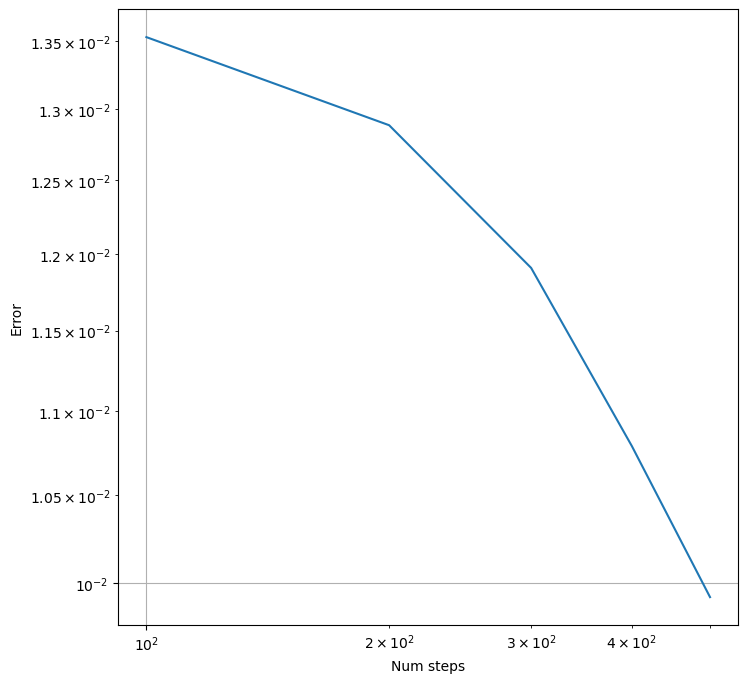

In [56]:
fig = plt.figure()
plt.figure(figsize=(8,8))
plt.plot(num_steps, error, linestyle="solid")
plt.xlabel("Num steps")
plt.ylabel("Error")
plt.grid()
plt.yscale("log")
plt.xscale("log")
;

In [32]:
function analitical_B(t, b, x0, y0)
    r = abs((m_e*v) / (q_e*B))
    w = -(q_e*b)/m_e
    k = w*t
    x = r * cos(k) - r + x0
    y = r * sin(k) + y0
    return [x, y, 0.3]
end

analitical_B (generic function with 1 method)

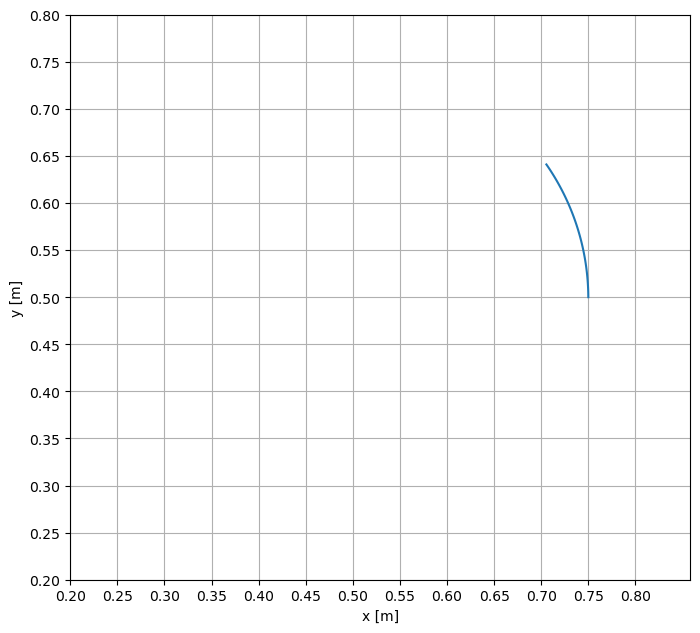

In [28]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
#plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

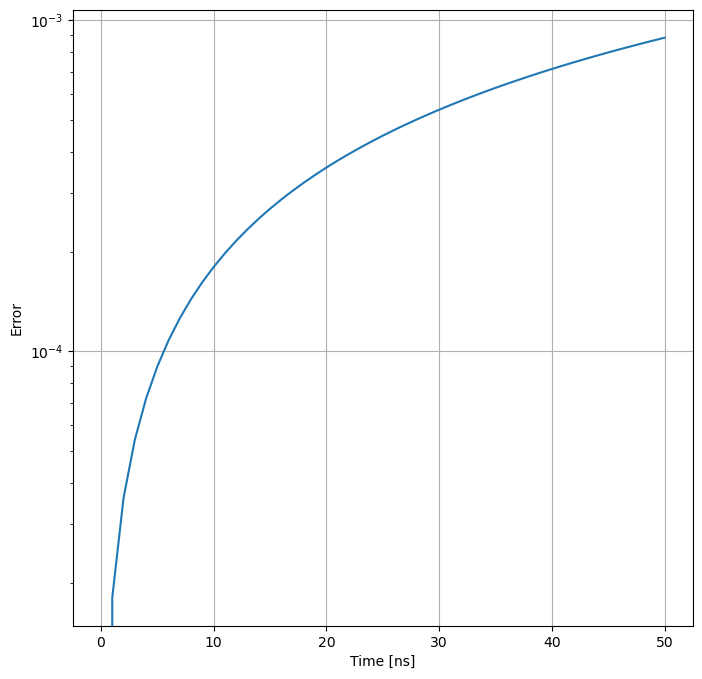

In [44]:
fig = plt.figure()
plt.figure(figsize=(8,8))
plt.plot(0:50, error, linestyle="solid")
plt.xlabel("Time [ns]")
plt.ylabel("Error")
plt.grid()
plt.yscale("log")
;

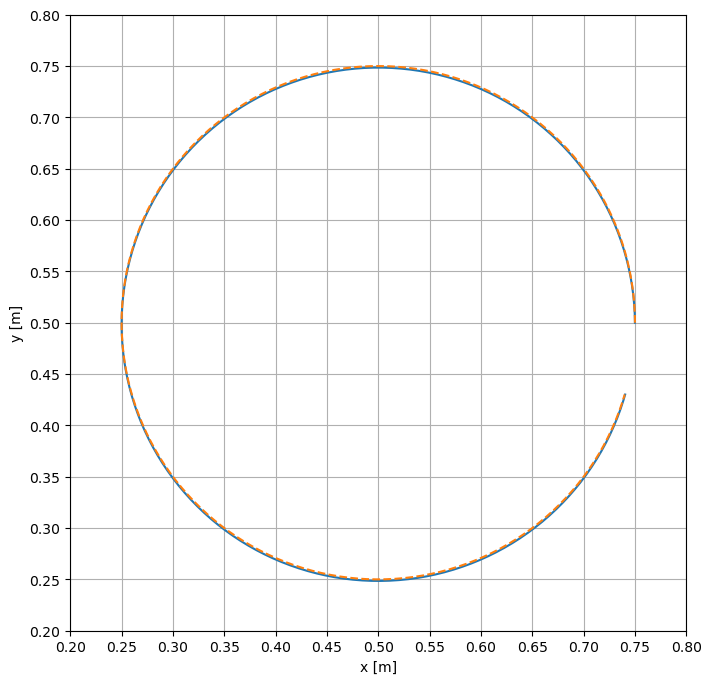

In [117]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

In [51]:
function get_dt_for_num_steps(v,B, num_steps)
    r = abs((m_e*v) / (q_e*B))
    l = 2*π*r
    num_steps = 100
    T = l / v
    dt = T / num_steps
    return dt
end

get_dt_for_num_steps (generic function with 2 methods)

5.236015443404827e-9

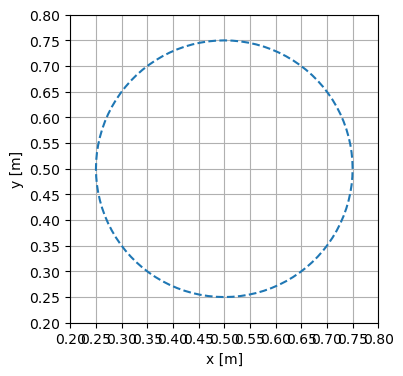

In [49]:
v = 3e6
B = 6.82272e-5
r = abs((m_e*v) / (q_e*B))
w = -(q_e*B)/m_e
xx_an = []
push!(xx_an, [0.75, 0.5])
l = 2*π*r
num_steps = 100
T = l / v
dt = T / num_steps
print(dt)
for t in 1:100
    t *= dt
    k = w*t
    x = r * cos(k) - r
    y = r * sin(k)
    push!(xx_an, [0.75, 0.5] + [x, y])
end

fig = plt.figure()
plt.figure(figsize=(4,4))
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

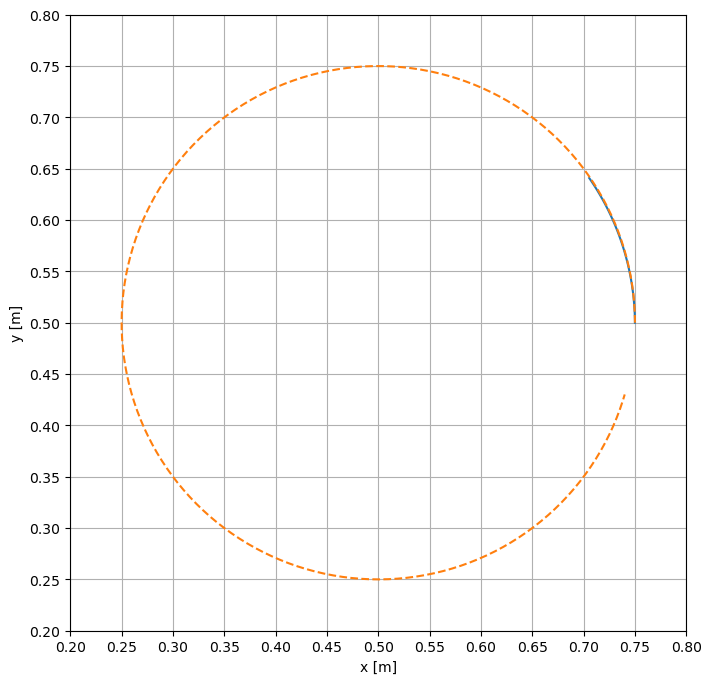

In [26]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

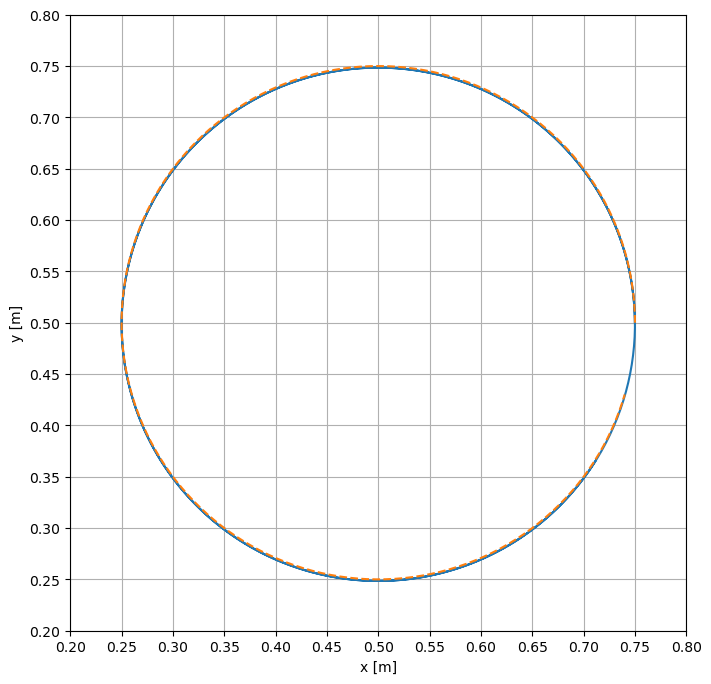

In [19]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

In [29]:
E_ex = [-1,0,0]
B_ex = [0,0,0]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = q_e
p1.x = [0,0,0]
Δt = 1e-10

vel = []
xx = []
push!(vel, [0,0,0])
push!(xx, [0,0,0])
for i = 1:50
    timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    push!(vel, particles[1].v)
    push!(xx, particles[1].x)
end

In [30]:
q_e = -1.60217662e-19 # charge of electron C = A*s
m_e = 9.10938356e-31 # mass of electron kg
a = (q_e/m_e) * [-1,0,0]
time = 1:5
time *= 1e-9
vel_an = [a*t for t in time]
xx_an = [(a*t^2 / 2) for t in time]
pushfirst!(vel_an, [0,0,0])
pushfirst!(xx_an, [0,0,0])
;

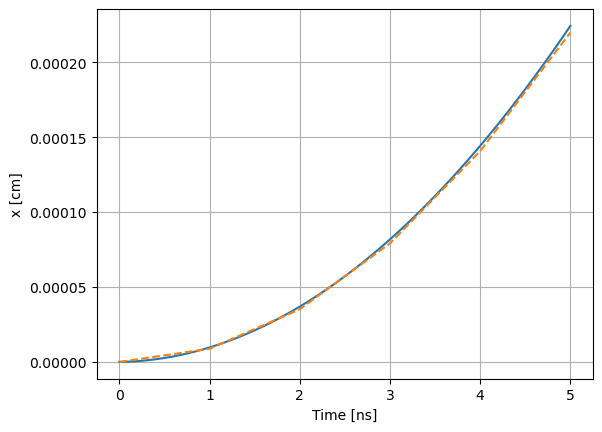

PyObject Text(24.0, 0.5, 'x [cm]')

In [31]:
plt.plot(0:0.1:5.0, [x[1]*100 for x in xx], linestyle="solid")
plt.plot(0:5, [x[1]*100 for x in xx_an], linestyle="dashed")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

In [14]:
function compute_EK_particles(particles)
    ek = 0
    for p in particles
        ek += p.m*dot(p.v,p.v)
    end
    ek *= 0.5
    return ek
end

function compute_EP_field(Ex, Ey, Ez, Δx, Δy, Δz)
    ep = 0
    for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
        ep += Ex[i,j,k]^2 + Ey[i,j,k]^2 + Ez[i,j,k]^2
    end
    ep = 0.5 * ε_0 * ep * Δx*Δy*Δz
    return ep
end

function compute_EP_potential(ρ, ϕ)
    ep = 0
    for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
        ep += ρ[i,j,k] * ϕ[i,j,k]
    end
    ep = 0.5*ε_0*ep
    return ep
end

compute_EP_potential (generic function with 1 method)

In [32]:
function generate_particles!(particles, np)
    num = 2.2e6
    for i = 1:np
        p1 = Particle()
        p1.x = [rand()*(gsize[1]-1)*Δx, Δy, Δz]
        p1.v = [5e5, 0, 0]
        p1.m = m_e*num
        p1.q = q_e*num
        p1.c = 1
        
        p2 = Particle()
        p2.x = [rand()*(gsize[1]-1)*Δx, Δy, Δz]
        p2.v = [-5e5, 0, 0]
        p2.m = m_e*num
        p2.q = q_e*num
        p2.c = 2
        push!(particles, p1)
        push!(particles, p2)       
    end

    for i = 1:np*2
        p3 = Particle()
        p3.x = [rand()*(gsize[1]-1)*Δx, Δy, Δz]
        p3.v = [0, 0, 0]
        p3.m = m_e*num*2000
        p3.q = -q_e*num
        push!(particles, p3)
    end
end

generate_particles! (generic function with 1 method)

In [ ]:
#Two stream instability
E_ex = [0,0,0]
B_ex = [0,0,0]
np = 2048
particles = []
generate_particles!(particles, np)
Δt = 1e-9

historyxx = []
historyvel = []
# EK = [0.0]
# EE = [0.0]
# EP = [0.0]
for i = 1:400
    timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    if i % 25 == 0
        plt.figure()
        plt.scatter([p.x[1] for p in particles if p.c == 1], [p.v[1] for p in particles if p.c == 1], color="red", label="c = 1", s=2)
        plt.scatter([p.x[1] for p in particles if p.c == 2], [p.v[1] for p in particles if p.c == 2], color="blue", label="c = 2", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[p.x...] for p in particles])
        push!(historyvel, [[p.v...] for p in particles])
    end
    # push!(EK, compute_EK_particles(particles))
    # push!(EE, compute_EP_field(Ex, Ey, Ez, Δx, Δy, Δz))
    # push!(EP, compute_EP_potential(ρ, ϕ))
end

In [20]:
particles[1].v

3-element Vector{Float64}:
 499999.9999779988
      3.406597773355427e-5
     -1.8285961205455465e-6

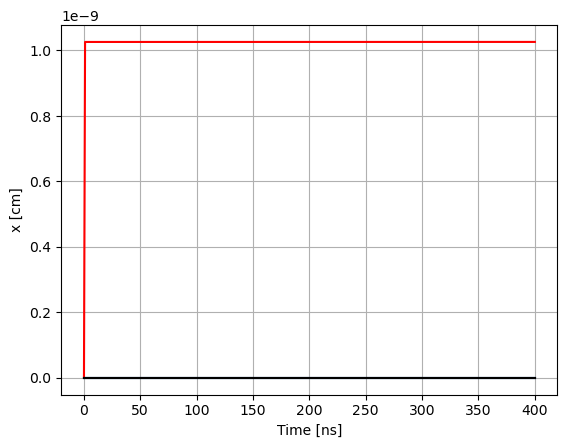

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [17]:
fig = plt.figure()
plt.plot(0:400, EK, linestyle="solid", color="red")
plt.plot(0:400, EE, linestyle="solid", color="blue")
plt.plot(0:400, EP, linestyle="solid", color="green")
plt.plot(0:400, EE .+ EP, linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

In [ ]:
for i = 1
    println("B")
    println(i)
    timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    if i % 2 == 0
        plt.figure()
        plt.scatter([p.x[1] for p in particles if p.c == 1], [p.v[1] for p in particles if p.c == 1], color="red", label="c = 1")
        plt.scatter([p.x[1] for p in particles if p.c == 2], [p.v[1] for p in particles if p.c == 2], color="blue", label="c = 2")
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[p.x...] for p in particles])
        push!(historyvel, [[p.v...] for p in particles])
    end
end

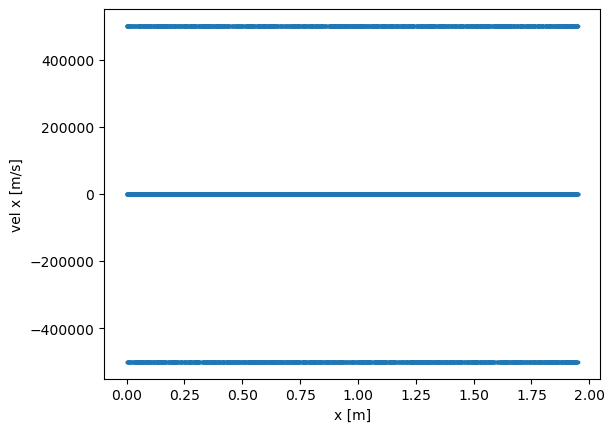

In [21]:
plt.figure()
plt.scatter([p.x[1] for p in particles], [p.v[1] for p in particles], s =3)
plt.xlabel("x [m]")
plt.ylabel("vel x [m/s]")
plt.show()

In [42]:
size(historyxx)

(40,)

MovieWriter ffmpeg unavailable; using Pillow instead.


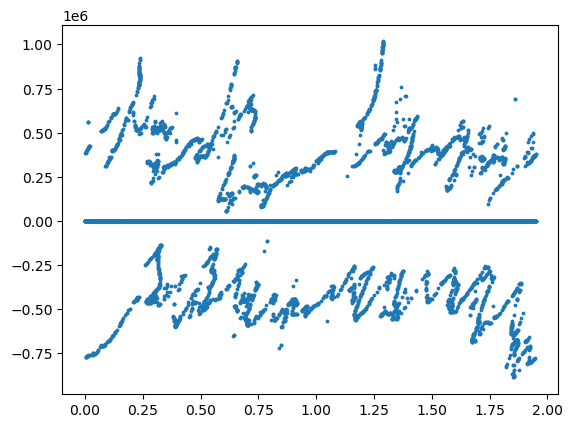

In [12]:
fig = plt.figure()
plt.scatter([p.x[1] for p in particles], [p.v[1] for p in particles], s =3)

function make_frame(i)
    plt.clf()
    plt.scatter([p[1] for p in historyxx[i+1]], [p[1] for p in historyvel[i+1]], s =3)
end

myanim = anim.FuncAnimation(fig, make_frame, frames=40, interval=200, blit=false)
myanim[:save]("test.gif", bitrate=-1)


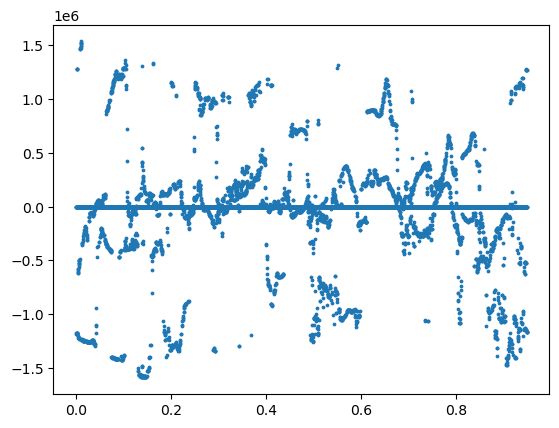

PyObject <matplotlib.collections.PathCollection object at 0x00000199615C6D40>

In [62]:
plt.scatter([p[1] for p in historyxx[1]], [p[1] for p in historyvel[1]], s =3)

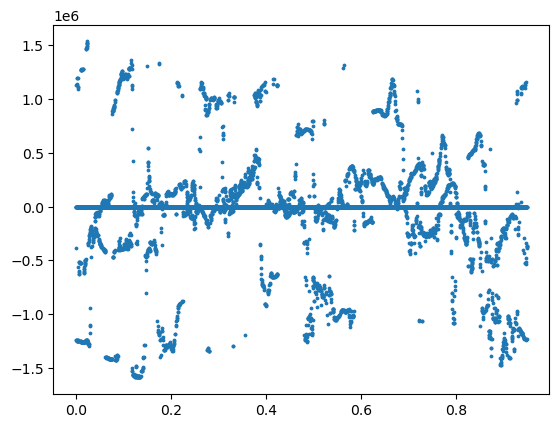

PyObject <matplotlib.collections.PathCollection object at 0x0000019961547220>

In [61]:
plt.scatter([p[1] for p in historyxx[2]], [p[1] for p in historyvel[2]], s =3)